## Canny边缘检测

在计算机视觉中，Canny边缘检测是一种经典的边缘检测算法，用于从图像中提取显著的边缘。该算法通过一系列步骤来检测边缘，主要包括以下几个阶段：

1. **高斯滤波**：先对图像进行高斯模糊以减少噪声，因为噪声会影响边缘检测的效果。
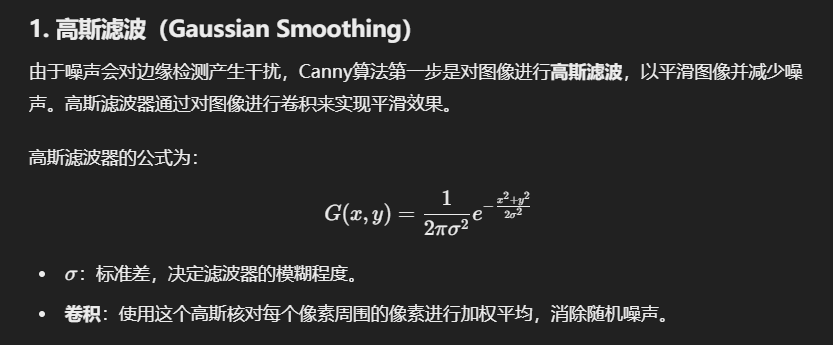
2. **计算梯度**：计算图像的梯度（x方向和y方向），从而找到图像中灰度变化较大的区域，即可能的边缘位置。
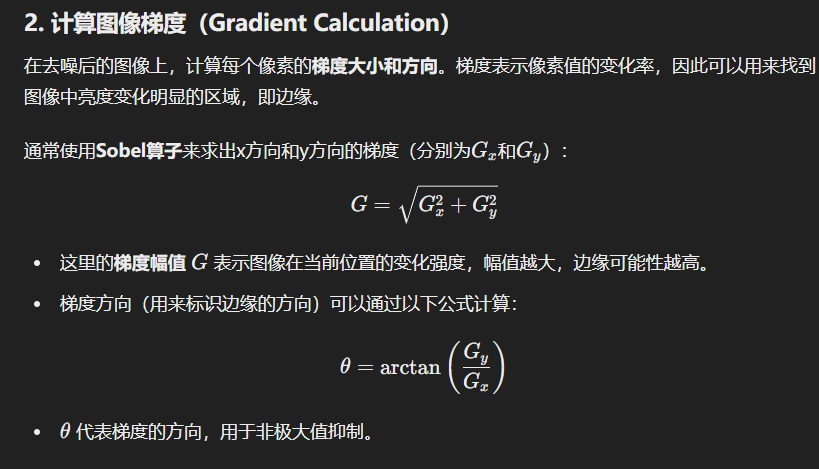
3. **非极大值抑制**：在边缘的方向上抑制非极大值，保留局部梯度值最大的像素点，增强边缘线的清晰度。
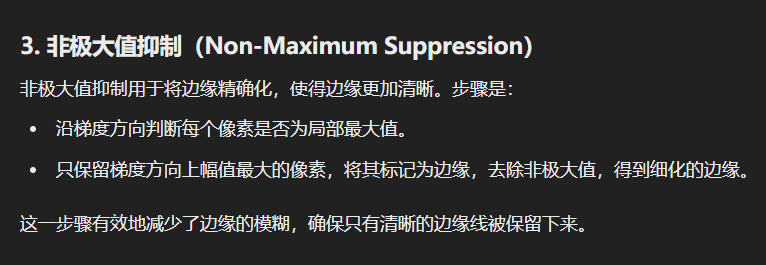
4. **双阈值检测**：通过两个阈值筛选边缘像素，标记出强边缘和弱边缘。
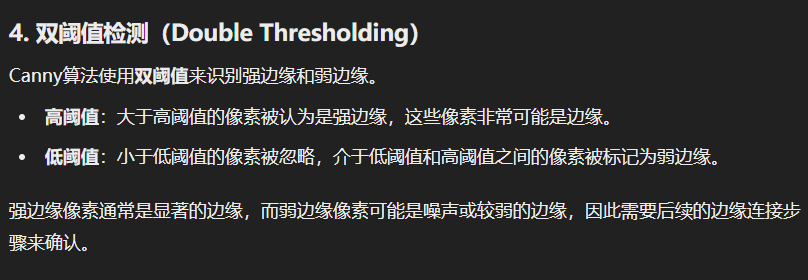
5. **边缘连接**：通过连接强边缘和弱边缘，最终确定图像的边缘。
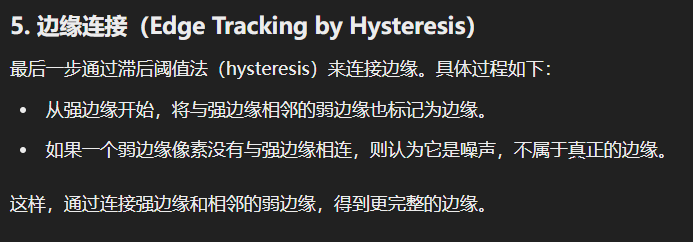

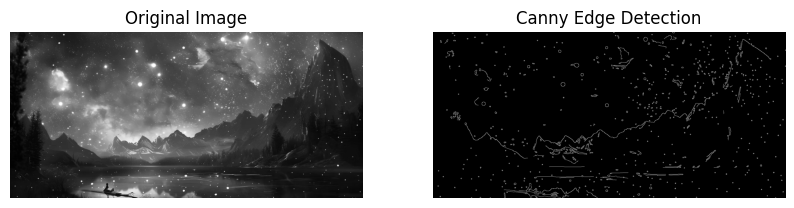

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def canny_edge_detection(image_path):
    # 1. 读取图像
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("图像路径无效或图像读取失败。")

    # 2. 高斯滤波（用于去噪）
    blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)

    # 3. 应用Canny边缘检测
    # 可以调整low_threshold和high_threshold来控制边缘检测的灵敏度
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blurred_image, low_threshold, high_threshold)

    # 4. 显示原图与边缘检测结果
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Canny Edge Detection")
    plt.imshow(edges, cmap='gray')
    plt.axis("off")

    plt.show()

# 图像路径
canny_edge_detection("data/Beauitful.png")


为了使Canny边缘检测更加自适应，我们可以通过动态计算双阈值，使得算法在处理不同图像时能更好地适应其内容。这可以通过分析图像的梯度分布来自动选择阈值。

一种常用的自适应方法是根据图像梯度的中位数来动态调整阈值，比如：
- **低阈值**设置为中位数梯度的0.33倍。
- **高阈值**设置为中位数梯度的1.33倍。

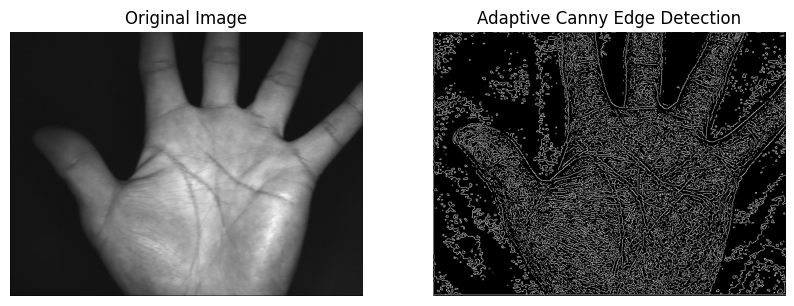

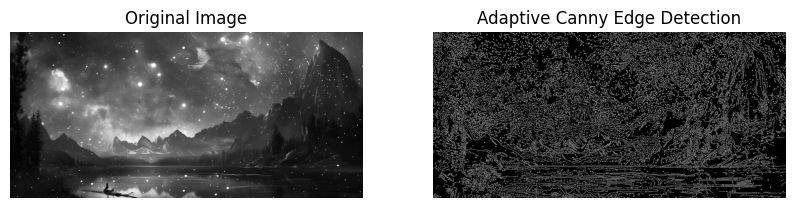

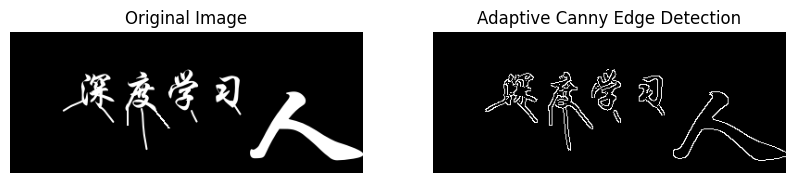

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def adaptive_canny_edge_detection(image_path):
    # 1. 读取图像
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("图像路径无效或图像读取失败。")

    # 2. 高斯滤波（用于去噪）
    blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)

    # 3. 计算图像的梯度幅值
    sobelx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)  # x方向梯度
    sobely = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)  # y方向梯度
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

    # 4. 计算梯度的中位数，设置自适应阈值
    median_gradient = np.median(gradient_magnitude)
    low_threshold = int(max(0, 0.33 * median_gradient))
    high_threshold = int(min(255, 1.33 * median_gradient))

    # 5. 应用自适应Canny边缘检测
    edges = cv2.Canny(blurred_image, low_threshold, high_threshold)

    # 6. 显示原图与边缘检测结果
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Adaptive Canny Edge Detection")
    plt.imshow(edges, cmap='gray')
    plt.axis("off")

    plt.show()

# 图像路径
adaptive_canny_edge_detection("data/00001.tiff")
adaptive_canny_edge_detection("data/Beauitful.png")
adaptive_canny_edge_detection("data/sd.png")

## 非极大值抑制
非极大值抑制（Non-Maximum Suppression）是Canny边缘检测的核心步骤之一，用于确保边缘检测结果的清晰度。其主要目的是在梯度方向上只保留梯度幅值最大的像素点，将其他非极大值的像素置为零，从而突出边缘的线条。

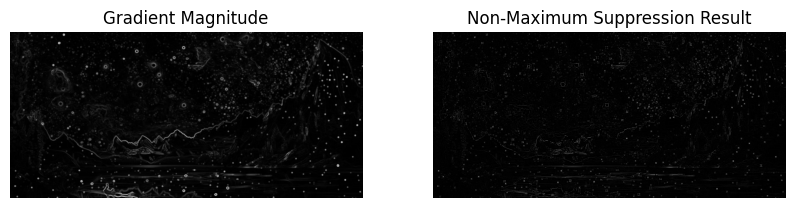

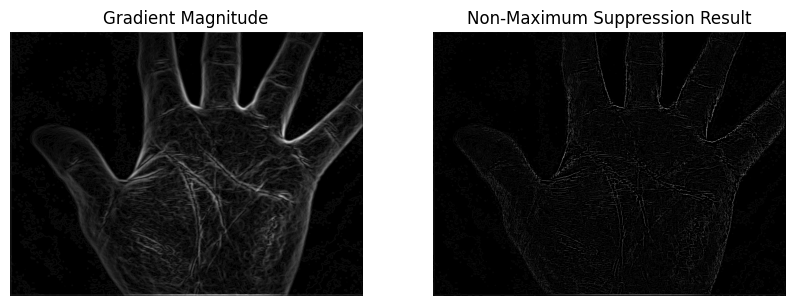

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def non_maximum_suppression(gradient_magnitude, gradient_direction):
    # 获取图像尺寸
    rows, cols = gradient_magnitude.shape
    suppressed = np.zeros((rows, cols), dtype=np.uint8)

    # 转换梯度方向角度到 0-180 度范围内
    gradient_direction = gradient_direction % 180

    # 遍历图像像素（除去边缘）
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            # 获取当前像素的梯度方向
            angle = gradient_direction[i, j]

            # 确定与梯度方向对应的像素比较方向
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                before, after = gradient_magnitude[i, j-1], gradient_magnitude[i, j+1]
            elif 22.5 <= angle < 67.5:
                before, after = gradient_magnitude[i-1, j+1], gradient_magnitude[i+1, j-1]
            elif 67.5 <= angle < 112.5:
                before, after = gradient_magnitude[i-1, j], gradient_magnitude[i+1, j]
            else:
                before, after = gradient_magnitude[i-1, j-1], gradient_magnitude[i+1, j+1]

            # 进行非极大值抑制
            if gradient_magnitude[i, j] >= before and gradient_magnitude[i, j] >= after:
                suppressed[i, j] = gradient_magnitude[i, j]
            else:
                suppressed[i, j] = 0

    return suppressed

def canny_with_non_max_suppression(image_path):
    # 1. 读取图像并转换为灰度
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("图像路径无效或图像读取失败。")

    # 2. 高斯滤波（去噪）
    blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)

    # 3. 计算梯度幅值和梯度方向
    sobelx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_direction = np.arctan2(sobely, sobelx) * (180 / np.pi)

    # 4. 应用非极大值抑制
    nms_result = non_maximum_suppression(gradient_magnitude, gradient_direction)

    # 5. 显示结果
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Gradient Magnitude")
    plt.imshow(gradient_magnitude, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Non-Maximum Suppression Result")
    plt.imshow(nms_result, cmap='gray')
    plt.axis("off")

    plt.show()

# 使用示例，替换为本地图像路径
canny_with_non_max_suppression("Beauitful.png")
canny_with_non_max_suppression("00001.tiff")
